In [1]:
import pandas as pd
import numpy as np
import json
import joblib
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

import warnings
import os

import multiprocessing
cores = multiprocessing.cpu_count()

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

FILE_DIR = './artifacts/'
if not os.path.exists(FILE_DIR):
    os.mkdir(FILE_DIR)

In [2]:
def import_data():
    data = pd.read_csv('norway_new_car_sales_by_make.csv')
    data['Period'] = data['Year'].astype(str) + "-" + data['Month'].astype(str)
    data['Period'] = pd.to_datetime(data['Period']).dt.strftime('%Y-%m')
    df = pd.pivot_table(data=data, values='Quantity', index='Make', columns='Period', aggfunc='sum', fill_value=0)
    return df

In [3]:
df = import_data()
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [4]:
def datasets(df, x_len=12, y_len=1, y_test_len=12, y_val_len=12):
    D = df.values
    periods = D.shape[1]

    # Training set creation: run through all the possible time windows
    loops = periods + 1 - x_len - y_len - y_val_len - y_test_len 
    train = []
    for col in range(loops):
        train.append(D[:,col:col + x_len + y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[x_len],axis=1)
    
    # Validation set creation
    max_col_val = periods + 1 -x_len - y_len - y_test_len
    val = []
    for col in range(loops, max_col_val):
        val.append(D[:,col:col + x_len + y_len])
    val = np.vstack(val)
    X_val, Y_val = np.split(val, [x_len], axis=1)

    # Test set creation: unseen “future” data with the demand just before
    max_col_test = periods + 1 - x_len - y_len
    test = []
    for col in range(max_col_val, max_col_test):
        test.append(D[:,col:col+x_len+y_len])
    test = np.vstack(test)
    X_test, Y_test = np.split(test,[x_len],axis=1)

    # this data formatting is needed if we only predict a single period
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_val = Y_val.ravel()
        Y_test = Y_test.ravel()

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [5]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = datasets(df)

In [6]:
def get_model(params):
    if params['regressor'] == 'DecisionTreeRegressor':
        criterion = params['params']['dt_criterion']
        max_depth = params['params']['dt_max_depth']
        min_samples_leaf = params['params']['dt_min_samples_leaf']
        max_features = params['params']['dt_max_features']
        
        model = DecisionTreeRegressor(criterion=criterion,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features)
    else:
        criterion = params['params']['rf_criterion']
        n_estimators = params['params']['rf_n_estimators']
        min_samples_leaf = params['params']['rf_min_samples_leaf']
        max_features = params['params']['rf_max_features']
        
        model = RandomForestRegressor(criterion=criterion,
                                      n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features)
        
    return model

In [7]:
def trainModel(params):
    model = get_model(params)
    print('Fiting model...')
    model.fit(X_train, Y_train)
    
    return model

In [8]:
def get_params_space():
    criterion = ['mse', 'mae']
    max_depth = [5, 7, 9, 11, 13]
    min_samples_leaf = [1, 2, 3, 4]
    max_features = ['auto']
    n_estimators = [32, 64, 128]
    params_space = hp.choice('regressor_type', [
        {'regressor': 'DecisionTreeRegressor',
         'params': {
             'dt_criterion': hp.choice('dt_criterion', criterion),
             'dt_max_depth': hp.choice('dt_max_depth', max_depth),
             'dt_min_samples_leaf': hp.choice('dt_min_samples_leaf', min_samples_leaf),
             'dt_max_features': hp.choice('dt_max_features', max_features)
        }},
        {'regressor': 'RandomForestRegressor',
        'params': {
            'rf_criterion': hp.choice('rf_criterion', criterion),
            'rf_n_estimators': hp.choice('rf_n_estimators', n_estimators),
            'rf_max_depth': hp.choice('rf_max_depth', max_depth),
            'rf_min_samples_leaf': hp.choice('rf_min_samples_leaf', min_samples_leaf),
            'rf_max_features': hp.choice('rf_max_features', max_features)           
        }}
    ])
    return params_space

In [9]:
def objective(params):
    model = get_model(params)
    model.fit(X_train, Y_train)
    
    Y_val_pred = model.predict(X_val) 
#     MAE_val = np.mean(abs(Y_val - Y_val_pred))/np.mean(Y_val)
#     MAE_val = mean_absolute_error(Y_val, Y_val_pred)
    MSE_val = mean_squared_error(Y_val, Y_val_pred)
#     val_loss = MAE_val
    val_loss = MSE_val 
    val_r2 = r2_score(Y_val, Y_val_pred)
    
    return {'loss':val_loss, 'status': STATUS_OK, 'r2score': val_r2, 'trained_model': model}

In [10]:
def unpack_hyperopt_vals(vals):
    """Unpack values from a hyperopt return dictionary where values are wrapped in a list.
    
    :param vals: dict
    :return: dict:copy of the dictionary with unpacked values
    """
    
    assert isinstance(vals, dict), "parameter must be given as dict."
    ret = {}
    for k, v in list(vals.items()):
        try:
            ret[k] = v[0]
        except (TypeError, IndexError):
            ret[k] = v
    return ret

In [11]:
def train_model_tune_parameters(space):
    runs = Trials()
    best = fmin(objective, space, algo=tpe.suggest, trials=runs, max_evals=100, rstate=np.random.RandomState(42))
    best_params = space_eval(space, best)
    
    print('\nBest model type selected: ' + best_params['regressor'])
    print('\nBest model params: ' + json.dumps(best_params, indent=4))
    
    return runs, best, best_params

In [12]:
def getBestResultfromTrials(bestrun, trials):
    for i, trial in enumerate(trials):
        vals = trial.get('misc').get('vals')
        # unpack the values from list without overwriting the mutable dict within trial'
        unpacked_vals = unpack_hyperopt_vals(vals)
        # identify the best run (comes with unpacked values from the hyperopt function `base.Trials.argmin`)
        if unpacked_vals == bestrun and 'trained_model' in trial.get('result').keys():
            best_trial_obj = trial
            break
    del bestrun, trials
    return best_trial_obj.get('result')

In [13]:
def plot_accuracy_loss_per_step(tuned_trials):
    r2_y = np.array([t['r2score'] for t in tuned_trials.results])
    r2_x = np.arange(1, len(r2_y) + 1, 1)
    
    r2_y_max = np.max(r2_y)
    best_r2_y = r2_y[r2_y == r2_y_max]
    best_r2_y_xs = r2_x[r2_y == r2_y_max]
    
    loss_y = np.array([t['loss'] for t in tuned_trials.results])
    loss_x = np.arange(1, len(loss_y) + 1, 1)
    
    loss_y_min = np.min(loss_y)
    best_loss_y = loss_y[loss_y == loss_y_min]
    best_loss_y_xs = loss_x[loss_y == loss_y_min]
    
    # just to calculate a locally weighted average
    r2_reg = KNeighborsRegressor()
    r2_reg.fit(r2_x.reshape(-1,1), r2_y)
    r2_preds = r2_reg.predict(r2_x.reshape(-1, 1))
    
    loss_reg = KNeighborsRegressor()
    loss_reg.fit(loss_x.reshape(-1,1), loss_y)
    loss_preds = loss_reg.predict(loss_x.reshape(-1, 1))
    
    fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(16,6))
    
    ax1.plot(r2_x, r2_y, 'go', alpha=0.5)
    ax1.plot(best_r2_y_xs, best_r2_y, 'ro')
    ax1.plot(r2_x, r2_preds, '--')    
    ax1.set_ylabel('Adjusted R-squared')
    ax1.set_xlabel('Iteration')
    ax1.set_title('Adj. R squared Per Step')
    
    ax2.plot(loss_x, loss_y, 'go', alpha=0.5)
    ax2.plot(best_loss_y_xs, best_loss_y, 'ro')
    ax2.plot(loss_x, loss_preds, '--')    
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Iteration')
    ax2.set_title('Loss Per Step')

In [14]:
def predict(model, test_input):
    preds = model.predict(test_input)
    return preds

In [20]:
def print_metrices(predictions, y):
    print('Mean Squared Error for test set\n')
    print('MSE: ', mean_squared_error(y, predictions))
    print('Adjusted R squared for test set\n')
    print('R2_Score: ', r2_score(y, predictions))

100%|███████████████████████████████████████████████| 100/100 [48:08<00:00, 28.89s/trial, best loss: 7596.950692279523]

Best model type selected: RandomForestRegressor

Best model params: {
    "params": {
        "rf_criterion": "mae",
        "rf_max_depth": 9,
        "rf_max_features": "auto",
        "rf_min_samples_leaf": 2,
        "rf_n_estimators": 64
    },
    "regressor": "RandomForestRegressor"
}
Tuning completed...


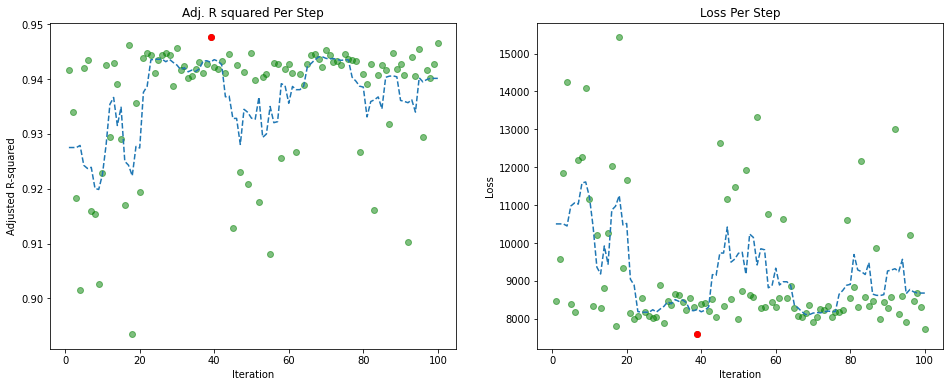

In [16]:
# Hyper-parameter tuning
param_space = get_params_space()
tuned_trials, best_run, tuned_params = train_model_tune_parameters(param_space)
plot_accuracy_loss_per_step(tuned_trials)
joblib.dump(tuned_params, FILE_DIR + 'best_params.pkl')
# best_trial_result = getBestResultfromTrials(best_run, tuned_trials)
# best_model = best_trial_result['trained_model']
print('Tuning completed...')

In [21]:
# Training with tuned parameters
tuned_params = joblib.load(FILE_DIR + 'best_params.pkl')
model_type = tuned_params['regressor']
print(f'Model selected for training: {model_type}')
trained_model = trainModel(tuned_params)
preds_test = predict(trained_model, X_test)
print_metrices(preds_test, Y_test)
joblib.dump(trained_model, FILE_DIR + 'best_model.pkl')
print('Training Completed...')

Model selected for training: RandomForestRegressor
Fiting model...
Mean Squared Error for test set

MSE:  10795.915307382436
Adjusted R squared for test set

R2_Score:  0.9323491582881756
Training Completed...
